In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import statistics
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from functools import partial
import warnings

warnings.filterwarnings('ignore')


In [2]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [3]:
import train_tabular_utils as tt
import cv_split_utils
import enums
import data_utils

In [4]:
class Config:
    RUN_MODE = "LOCAL"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "price"        
    SCALER = enums.Scaler.StandardScaler
    METRIC = enums.Metrics.RMSE
    # These values are more dynamic   
    MODEL_TYPE = enums.ModelName.CatBoost
    NUM_TUNING_TRIALS = 25
    TUNE_ON_SINGLE_FOLD = True
    TRAIN_SINGLE_FOLD = True    
    PERSIST_MODEL = False    
    USE_MANUAL_FEATURES = True
    USE_ORIGINAL_DATA = False    
    FEATURE_SELECTION_METHOD = None
    NUM_CLASSES = None

COLS_TO_LEAVE = ["id", "price", "kfold", "transmission_speed"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
DATA_WRITEPATH = "./output/"
SUBMISSION_FILEPATH = DATA_READPATH
if Config.RUN_MODE == "KAGGLE":    
    DATA_READPATH = "/kaggle/input/playground-series-s4e6/"
    if Config.USE_OPENFE_FEATURES:
        DATA_READPATH = "/kaggle/input/ps4e6-openfe/"
    SUBMISSION_FILEPATH = "/kaggle/input/playground-series-s4e6/"
    DATA_WRITEPATH = "/kaggle/working/"

In [5]:
model_static_params = {
    enums.ModelName.XGBoost: {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "seed": Config.RANDOM_SEED,
        "verbosity": 0,
    },
    enums.ModelName.LGBM: {
        "objective": "root_mean_squared_error",
        "metric": 'rmse',
        "verbosity": -1,    # <0: fatal, =0: error (warn), =1: info, >1: debug
        "boosting_type": "gbdt"
    },
    enums.ModelName.CatBoost: {
        "objective": "RMSE",
        "verbose": 0,
        "random_seed": Config.RANDOM_SEED,
        "eval_metric": "RMSE",
        'grow_policy':  'Lossguide',
        #'bootstrap_type': 'Poisson',
        'task_type': 'CPU'
    },
    enums.ModelName.RandomForest: {
        "random_state": Config.RANDOM_SEED,
        "n_jobs": -1
    }
}

In [6]:
# For RandomForest
# tuned_model_params = {'n_estimators': 1300, 'max_depth': 17, 'min_samples_leaf': 3, 'min_samples_split': 3, 'max_features': 'sqrt'}
# For CatBoost
# tuned_model_params = {
#     'iterations': 1500,
#     'depth': 5,
#     'learning_rate': 0.05602656173812734,
#     'l2_leaf_reg': 3.96021970280269,
#     'bagging_temperature': 8.793196499678535,
#     'border_count': 185,
#     'loss_function': 'RMSE',
#     'eval_metric': 'RMSE',
# }
# For XGBoost
# tuned_model_params = {'n_estimators': 1400, 'learning_rate': 0.10270166896064774, 'max_depth': 30, 'min_child_weight': 7, 'gamma': 4.123490349502186, 'subsample': 0.5067185283456936, 'colsample_bytree': 0.7289930512882908, 'reg_alpha': 0.5971832077526927, 'reg_lambda': 9.433125479981229, 'early_stopping_rounds': 260}
# For LGBM
# tuned_model_params = {'learning_rate': 0.050431114227825063, 'n_estimators': 1500, 'max_depth': 6, 'min_data_in_leaf': 92, 'min_child_weight': 6, 'num_leaves': 428, 'reg_lambda': 130.60718838770154, 'early_stopping_rounds': 365, 'subsample': 0.8586720764925466, 'colsample_bytree': 0.5962542688745494, 'reg_alpha': 0.5737569015209647}

tuned_model_params = None

In [7]:
if Config.USE_MANUAL_FEATURES:
    df_train = pd.read_csv(DATA_READPATH + "train_preprocessed.csv")
    df_test = pd.read_csv(DATA_READPATH + "test_preprocessed.csv")
else:
    df_train = pd.read_csv(DATA_READPATH + "train.csv")
    df_test = pd.read_csv(DATA_READPATH + "test.csv")
# keep a copy of original train and test data for later use
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

In [8]:
df_train = cv_split_utils.kfold_dataframe(df_train, random_state=Config.RANDOM_SEED, num_folds=Config.NUM_FOLDS)

In [9]:
imputation_config = None
if Config.USE_MANUAL_FEATURES:
    # Define imputation configuration
    imputation_config = {
        'horsepower': SimpleImputer(strategy='median'),
        'capacity': SimpleImputer(strategy='median'),
        'cylinders': SimpleImputer(strategy='most_frequent')
    }

In [10]:
# for fold in range(Config.NUM_FOLDS):
#     df_train_fold, df_val_fold = tt.get_fold_df(df_train, fold)    
#     # Impute 'horsepower' with median
#     horsepower_imputer = SimpleImputer(strategy='median')
#     horsepower_imputer.fit(df_train_fold[['horsepower']])
#     df_train_fold['horsepower'] = horsepower_imputer.transform(df_train_fold[['horsepower']])
#     df_val_fold['horsepower'] = horsepower_imputer.transform(df_val_fold[['horsepower']])
#     # Impute 'capacity' with median
#     capacity_imputer = SimpleImputer(strategy='median')
#     capacity_imputer.fit(df_train_fold[['capacity']])
#     df_train_fold['capacity'] = capacity_imputer.transform(df_train_fold[['capacity']])
#     df_val_fold['capacity'] = capacity_imputer.transform(df_val_fold[['capacity']])    
#     # Impute 'cylinders' with median
#     cylinders_imputer = SimpleImputer(strategy='most_frequent')
#     cylinders_imputer.fit(df_train_fold[['cylinders']])
#     df_train_fold['cylinders'] = cylinders_imputer.transform(df_train_fold[['cylinders']])
#     df_val_fold['cylinders'] = cylinders_imputer.transform(df_val_fold[['cylinders']])

In [11]:
# COLS_TO_LEAVE = COLS_TO_LEAVE + ['horsepower', 'fuel', 'engine', 'transmission', 'transmission_speed', 'capacity', 'cylinders']

In [12]:
df_train.fillna({"clean_title": "Unknown", "accident": "Unknown", "fuel_type": "Unknown", "fuel": "Unknown"}, inplace=True)

In [13]:
# do not include 'id' column in the list of int columns
int_cols = [col for col in df_train.columns if df_train[col].dtypes == 'int64' and col not in COLS_TO_LEAVE]
float_cols = [col for col in df_train.columns if df_train[col].dtypes == 'float64']
bool_cols = [col for col in df_train.columns if df_train[col].dtypes == 'bool']
cat_cols = [col for col in df_train.columns if df_train[col].dtypes == 'object' and col not in COLS_TO_LEAVE]
feature_cols = [x for x in df_train.columns if x not in COLS_TO_LEAVE]

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  188533 non-null  int64  
 1   brand               188533 non-null  object 
 2   model               188533 non-null  object 
 3   model_year          188533 non-null  int64  
 4   milage              188533 non-null  int64  
 5   fuel_type           188533 non-null  object 
 6   engine              188533 non-null  object 
 7   transmission        188533 non-null  object 
 8   ext_col             188533 non-null  object 
 9   int_col             188533 non-null  object 
 10  accident            188533 non-null  object 
 11  clean_title         188533 non-null  object 
 12  price               188533 non-null  int64  
 13  horsepower          155274 non-null  float64
 14  capacity            181835 non-null  float64
 15  cylinders           166770 non-nul

In [15]:
print(feature_cols)
print(cat_cols)

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'horsepower', 'capacity', 'cylinders', 'fuel', 'turbo', 'hybrid', 'transmission_type', 'age']
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'fuel', 'transmission_type']


In [16]:
# Convert all categorical columns to string type
df_train[cat_cols] = df_train[cat_cols].astype(str)
#test_data[cat_cols] = test_data[cat_cols].astype(str)
# Initialize LabelEncoder
label_encoders = {col: LabelEncoder() for col in cat_cols}
# initialize target encoder
target_encoders = {col: TargetEncoder() for col in cat_cols}

# Apply LabelEncoder to each categorical column
for col in cat_cols:
    # df_train[col] = label_encoders[col].fit_transform(df_train[col])
    df_train[col] = label_encoders[col].fit_transform(df_train[col])
    #test_data[col] = label_encoders[col].transform(test_data[col])

In [17]:
# preprocessing
preprocessor = None
scaler = StandardScaler()
# onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore", categories=int_feature_categories)
preprocessor = ColumnTransformer(
    transformers=[                
        ("scaler", scaler, int_cols+float_cols),
        #("onehot", onehot_encoder, int_features),                
    ], remainder="passthrough"
)

In [18]:
def get_model_tuning_params(trial, model_name):
    if model_name == enums.ModelName.LogisticRegression:
        penalty = ['l1', 'l2']
        return {        
            "C": trial.suggest_loguniform("C", 1e-3, 100),
            "penalty": trial.suggest_categorical("penalty", penalty)
        }    
    if model_name == enums.ModelName.RandomForest:
        return {        
            "n_estimators": trial.suggest_int("n_estimators", 200, 3000, step=100),
            "max_depth": trial.suggest_int("max_depth", 10, 30),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 16),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
            "max_features": trial.suggest_categorical("max_features", ["log2", "sqrt", None])
        }
    if model_name == enums.ModelName.CatBoost:
        return get_catboost_tuning_params(trial)
    if model_name == enums.ModelName.XGBoost:
        return get_xgb_tuning_params_level2(trial) 
    if model_name == enums.ModelName.LGBM:
        return get_lgbm_tuning_params(trial)   

In [19]:
def hyperparams_tuning_objective(trial, model_name, preprocessor, df,  
                                 feature_cols, metric, target_col_name, single_fold=False, num_folds=5,
                                 imputation_config=None):               
    model_params = get_model_tuning_params(trial, model_name)    
    fold_metrics_model, _, _ = tt.train_and_validate(
                                        model_name=model_name,
                                        model_params=model_params,
                                        preprocessor=preprocessor,
                                        df=df,
                                        feature_cols=feature_cols,
                                        target_col_name=target_col_name,
                                        metric=metric,
                                        single_fold=single_fold,
                                        num_folds=num_folds,
                                        suppress_print=True,
                                        imputation_config=imputation_config
                                    )
    fold_metrics = [x[0] for x in fold_metrics_model]
    mean_metric = statistics.mean(fold_metrics)                
    return mean_metric

In [20]:
def tune_model_params(study_name, study_direction, num_trials, model_name, 
                      preprocessor, df,  feature_cols, metric, target_col_name, 
                      single_fold=False, num_folds=5, imputation_config=None):
    model_params_tuning_obj_partial = partial(
        hyperparams_tuning_objective,
        model_name=model_name,        
        preprocessor=preprocessor,        
        df=df,
        feature_cols=feature_cols,
        metric=metric,
        target_col_name=target_col_name,
        single_fold=single_fold,
        num_folds=num_folds,
        imputation_config=imputation_config
    )
    study = optuna.create_study(direction=study_direction, study_name=study_name)
    study.optimize(model_params_tuning_obj_partial, n_trials=num_trials)
    best_trial = study.best_trial
    print(f"Best trial: number = {best_trial.number}, value = {best_trial.value}, params = {best_trial.params}")
    return best_trial.params

In [21]:
# if tuned_model_params is None:
#     #df = df_train.sample(frac=0.1, random_state=Config.RANDOM_SEED)
#     tuned_model_params = tune_model_params(
#                             study_name=Config.MODEL_TYPE + "_ModelTuning", 
#                             study_direction="maximize",
#                             num_trials=Config.NUM_TUNING_TRIALS,
#                             model_name=Config.MODEL_TYPE,
#                             preprocessor=preprocessor,
#                             df=df_train,
#                             feature_cols=feature_cols,
#                             metric=Config.METRIC,
#                             target_col_name=Config.TARGET_COL_NAME,
#                             single_fold=Config.TUNE_ON_SINGLE_FOLD,
#                             num_folds=Config.NUM_FOLDS,
#                             imputation_config=imputation_config
#                     )

In [22]:
model_params = None
params_static = model_static_params.get(Config.MODEL_TYPE)
if tuned_model_params is not None:
    model_params = {**params_static, **tuned_model_params}
else:
    model_params = params_static

print(model_params)    

{'objective': 'RMSE', 'verbose': 0, 'random_seed': 42, 'eval_metric': 'RMSE', 'grow_policy': 'Lossguide', 'task_type': 'CPU'}


In [23]:
# # Calculate the correlation matrix
# correlation_matrix = df_train[feature_cols+[Config.TARGET_COL_NAME]].corr()

# # Plot the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
# plt.title('Feature Correlation Heatmap')
# plt.tight_layout()
# plt.show()

In [24]:
# from contextlib import suppress
# import catboost

# preprocessor = None
# df_oof_preds = pd.DataFrame()
# fold_metrics_model = []
# suppress_print = False    
# for fold in range(Config.NUM_FOLDS):
#     fold_model = tt.get_model(model_name=Config.MODEL_TYPE, params=model_params, metric=Config.METRIC)
#     df_train_fold, df_val_fold = tt.get_fold_df(df_train, fold)
#     if imputation_config is not None:
#         tt.impute_missing_values(df_train_fold, df_val_fold, imputation_config)
#     train_X, train_y, val_X, val_y = tt.get_train_val_nparray(df_train_fold, df_val_fold, feature_cols, Config.TARGET_COL_NAME)
#     # we let catboost perform scaling and categorical encoding, so no preprocessing needed
#     if preprocessor is not None:
#         train_X = preprocessor.fit_transform(train_X)
#         val_X = preprocessor.transform(val_X)
#     # Create Pool objects for train and validation data
#     train_pool = catboost.Pool(data=train_X, label=train_y, cat_features=cat_cols)
#     val_pool = catboost.Pool(data=val_X, label=val_y, cat_features=cat_cols)
#     fold_model = catboost.CatBoostRegressor(**model_params, cat_features=cat_cols)
#     verbose = model_params["verbose"]
#     fold_model.fit(X=train_pool, eval_set=val_pool, verbose=verbose)
#     df_fold_val_preds = df_val_fold[['kfold', Config.TARGET_COL_NAME]]
#     fold_val_metric, df_fold_val_preds = tt.get_fold_val_preds(fold_model, val_X, val_y, Config.METRIC, 
#                                                             df_fold_val_preds, num_classes=Config.NUM_CLASSES)
#     if not suppress_print:        
#         print(f"Fold {fold} - {Config.MODEL_TYPE} - {Config.METRIC} : {fold_val_metric}")                
#     df_oof_preds = pd.concat([df_oof_preds, df_fold_val_preds], axis=0)
#     fold_metrics_model.append((fold_val_metric, fold_model))
#     if Config.TRAIN_SINGLE_FOLD:
#         break
# cv = tt.get_eval_metric(Config.METRIC, df_oof_preds[Config.TARGET_COL_NAME], df_oof_preds['oof_preds'] )
# metrics = [item[0] for item in fold_metrics_model]
# mean_metric, std_metric = tt.get_metric_stats(metrics)
# if not suppress_print:    
#     print(f"{Config.MODEL_TYPE} metric={Config.METRIC} CV score = {cv}")                

In [25]:
%%time
fold_metrics_model, df_oof_preds, preprocessor = tt.train_and_validate(
        model_name=Config.MODEL_TYPE,
        model_params=model_params,
        preprocessor=None,
        df=df_train,
        feature_cols=feature_cols,
        target_col_name=Config.TARGET_COL_NAME,
        metric=Config.METRIC,
        single_fold=Config.TRAIN_SINGLE_FOLD,
        num_folds=Config.NUM_FOLDS,
        suppress_print=False,
        imputation_config=imputation_config,
        cat_features=cat_cols
)

Fold 0 - CatBoost - RMSE : 76427.47669513333
CatBoost metric=RMSE CV score = 76427.47669513333
CatBoost Mean RMSE = 76427.47669513333, std = 0.0
CPU times: user 5min 48s, sys: 45.4 s, total: 6min 34s
Wall time: 1min 5s


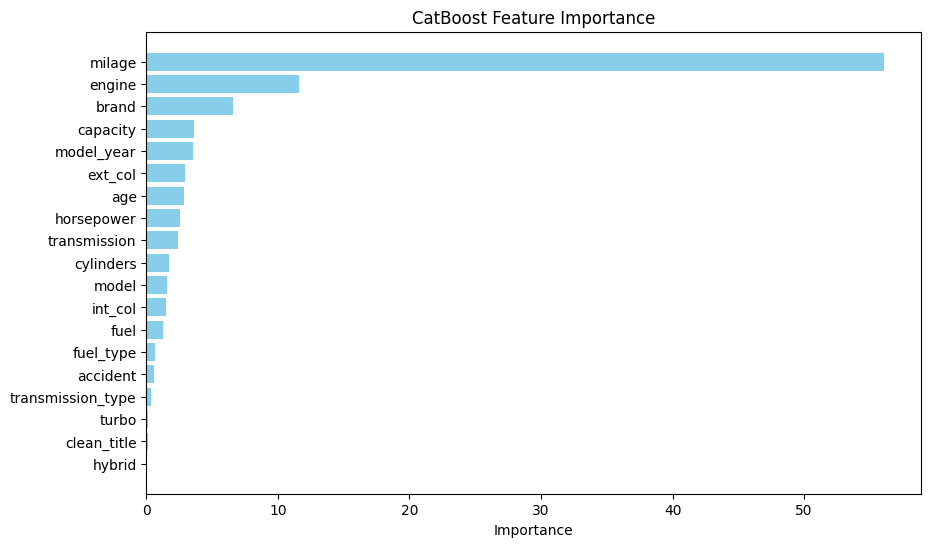

In [26]:
# Get feature importance
model = fold_metrics_model[0][1]
# Create a DataFrame for visualization
df_feature_imp = pd.DataFrame({
    'f_name': feature_cols,
    'f_imp': model.get_feature_importance()
})
# Sort the DataFrame by importance
df_feature_imp = df_feature_imp.sort_values(by='f_imp', ascending=False)
#data_utils.plot_feature_importance(df_feature_imp)
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(df_feature_imp['f_name'], df_feature_imp['f_imp'], color='skyblue')
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()
